# Example: Detecting Diabetes Types

In 1979, [Reaven, Miller & Alto](https://link.springer.com/article/10.1007/BF00423145)
analysed the difference between chemical and overt diabetes in 145 nonobese adults.
Previously, they had found a "horse shoe" relation between plasma glucose and insulin
response levels, confirmed by later studies. However, the interpretation of this
relationship remained unclear. It could be interpreted as the natural progression
of diabetes or as different underlying causes for the disease. In their 1979 work,
they attempted to quantify the relationship to gain insight into the pattern.


## Setup


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hdbscan import HDBSCAN
from flasc import FLASC
from sklearn.preprocessing import StandardScaler
from _plotting import *

%matplotlib inline
palette = configure_matplotlib()

## Data

To construct their dataset, they measure the insulin and glucose levels in
participants after controlling their diet and glucose intake through the
experimental protocol described in their paper. They analysed the participant's
relative weight, fasting plasma glucose levels, area under the plasma glucose
curve for a 3 hour glucose tolerance test (which quantifies how much and for
how long glucose remains in the blood), area under the plasma insulin curve
(similarly quantifying the insulin response), and the steady state plasma glucose
response (SSPG).

The data loaded in the cell below is copied from the
[Chemical and Overt Diabetes](https://link.springer.com/chapter/10.1007/978-1-4612-5098-2_37)
chapter in
[Data: A Collection of Problems from Many Fields for the Student and Research Worker](https://link.springer.com/book/10.1007/978-1-4612-5098-2).


In [3]:
df = pd.read_csv("./data/chemical_and_overt_diabetes.csv")
df.head()

,patient number,relative weight,fasting plasma glucose,glucose area,insulin area,sspg,clinical classification
0,1,0.81,80,356,124,55,3
1,2,0.95,97,289,117,76,3
2,3,0.94,105,319,143,105,3
3,4,1.04,90,356,199,108,3
4,5,1.00,90,323,240,143,3


In their paper, they show an artist's impression of a 3D insulin area, glucose
area, and SSPG scatter plot created using an early data visualization program
[PRIM-9](https://www.researchgate.net/figure/John-Tukey-in-front-of-the-PRIM-9-terminal_fig1_2489432).
They describe this plot as a "boomerang with two wings and a fat middle".

The cell below recreates the 3D plot:


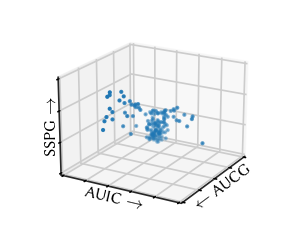

In [4]:
sized_fig(1 / 3, aspect=1.2)
ax = plt.gcf().add_subplot(projection="3d")
ax.scatter(df[" glucose area"], df[" insulin area"], df[" sspg"], s=1)
ax.set_yticks(ax.get_yticks())
ax.set_xticks(ax.get_xticks())
ax.set_zticks(ax.get_zticks())
ax.set_yticklabels(["" for t in ax.get_yticks()])
ax.set_xticklabels(["" for t in ax.get_xticks()])
ax.set_zticklabels(["" for t in ax.get_zticks()])
ax.set_xlabel("$\leftarrow$ AUCG", labelpad=-17, rotation=25)
ax.set_ylabel("AUIC $\\rightarrow$", labelpad=-17, rotation=-8)
ax.zaxis.set_rotate_label(False)  # disable automatic rotation
ax.set_zlabel("SSPG $\\rightarrow$", labelpad=-19, rotation=90)
ax.view_init(elev=20, azim=30)
plt.savefig("./images/diabetes_shape.png", dpi=300)
plt.show()

In a later [discussion by Miller](https://www.jstor.org/stable/2241186), he
describes this figure as "very interesting to the medical investigators. The
plump middle of the points roughly corresponds to normal patients, the right arm
to chemical diabetics and the left arm to overt diabetics." Afterwards, they were
also able to find this branching structure in 2D plots of these variables,
however, "it is not clear that merely examining the three [2D] plots ... would
have revealed the [structure] whereas it leaped out of the display screen for
the viewers with the PRIM-9 projections and rotations." Finally, he also
reflected on data exploration using computers: "While interesting shapes,
clusters, and separations are now more discoverable in high-dimensional data,
how do we evaluate whether these are real or merely random variation?"

[Singh et al. ](https://diglib.eg.org/bitstream/handle/10.2312/SPBG.SPBG07.091-100/091-100.pdf?sequence=1)
used this data set as an example of a dataset with branches that can be detected using Mapper.
They showed two Mapper networks with 3 and 4 50% overlapping cover segments over a
density kernel estimation as lens respectively.

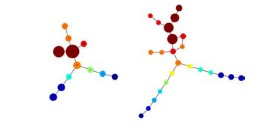

Here the branches are clearly visible. They argue that Mapper can automate finding
such branches even when they are not as clearly visible in 2D or 3D plots of the
data.


## FLASC

In the following section, we will show how FLASC can be used to analyze this
data. We normalize the columns to have a mean of 0 and unit standard deviation.
FLASC is configured to allow a single cluster with a minimum size of 10 points,
with the min samples and min branch size set to 5.

In [5]:
X = StandardScaler().fit_transform(df.iloc[:, 1:-1])
b = FLASC(
    min_samples=5,
    min_branch_size=5,
    min_cluster_size=10,
    allow_single_cluster=True,
).fit(X)
g = b.cluster_approximation_graph_

The resulting branch hierarchy indicates one larger and one smaller branch:


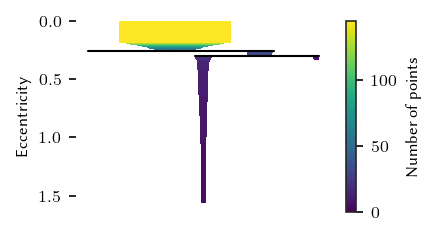

In [6]:
sized_fig(1 / 2)
n_clusters = len(b.cluster_persistence_)
for i in range(n_clusters):
    plt.subplot(1, n_clusters, i + 1)
    b.cluster_condensed_trees_[i].plot()
    if i == 0:
        plt.ylabel("Eccentricity")
    else:
        plt.axis("off")
plt.show()

The cluster approximation graph also nicely reveals the branching structure. Like
Mapper, FLASC can automate finding branches like this even when they are not
clearly visible in 2D or 3D plots.


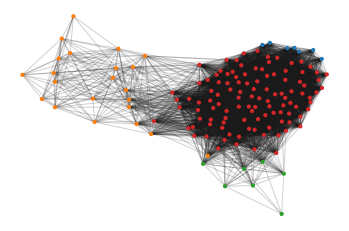

In [7]:
g.plot(
    node_size=10,
    edge_alpha=0.2,
)
plt.show()

In this case, the branches nicely capture the branches in the 3D plot:


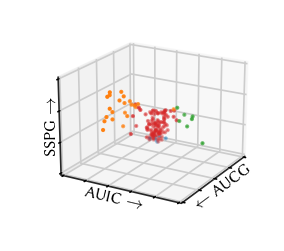

In [8]:
sized_fig(1 / 3, aspect=1.2)
ax = plt.gcf().add_subplot(projection="3d")
ax.scatter(
    df[" glucose area"],
    df[" insulin area"],
    df[" sspg"],
    s=1,
    c=[(0.8, 0.8, 0.8) if v == -1 else palette[v % 10] for v in b.labels_],
)
ax.set_yticks(ax.get_yticks())
ax.set_xticks(ax.get_xticks())
ax.set_zticks(ax.get_zticks())
ax.set_yticklabels(["" for t in ax.get_yticks()])
ax.set_xticklabels(["" for t in ax.get_xticks()])
ax.set_zticklabels(["" for t in ax.get_zticks()])
ax.set_xlabel("$\leftarrow$ AUCG", labelpad=-17, rotation=25)
ax.set_ylabel("AUIC $\\rightarrow$", labelpad=-17, rotation=-8)
ax.zaxis.set_rotate_label(False)  # disable automatic rotation
ax.set_zlabel("SSPG $\\rightarrow$", labelpad=-19, rotation=90)
ax.view_init(elev=20, azim=30)
# plt.title('FLASC', y=0.9)
plt.savefig("./images/diabetes_flasc.png", dpi=300)
plt.show()

## HDBSCAN\*

HDBSCAN\*, and density-based clustering in general, is not be able to detect the 
branching subgroups, as the branches do not have a local density maximum.
[Reaven, Miller & Alto](https://link.springer.com/article/10.1007/BF00423145)
were able to describe the branches using a $k$-means like procedure. However, they
knew the correct number for $k$ and had good initial locations available from a
previous analysis.

Using HDBSCAN\* with _min samples = 5_ and _min cluster size = 10&_ HDBSCAN\*
finds two clusters: one large cluster and one small cluster.


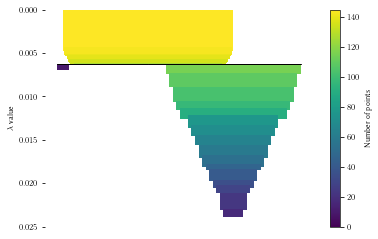

In [9]:
c = HDBSCAN(min_samples=5, min_cluster_size=10).fit(df)
c.condensed_tree_.plot()
plt.show()

Drawing the 3D plot with the HDBSCAN\* labels reveals HDBSCAN found the centre
and the beginning of the right-branch as one cluster. The beginning of the
left-branch is detected as the second cluster. For both branches, the outsides
are classified as noise.


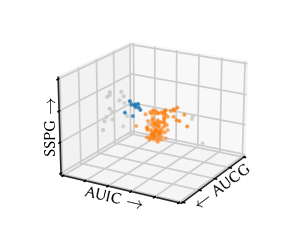

In [10]:
sized_fig(1 / 3, aspect=1.2)
ax = plt.gcf().add_subplot(projection="3d")
ax.scatter(
    df[" glucose area"],
    df[" insulin area"],
    df[" sspg"],
    s=1,
    c=[(0.8, 0.8, 0.8) if l == -1 else palette[l % 10] for l in c.labels_],
)
ax.set_yticks(ax.get_yticks())
ax.set_xticks(ax.get_xticks())
ax.set_zticks(ax.get_zticks())
ax.set_yticklabels(["" for t in ax.get_yticks()])
ax.set_xticklabels(["" for t in ax.get_xticks()])
ax.set_zticklabels(["" for t in ax.get_zticks()])
ax.set_xlabel("$\leftarrow$ AUCG", labelpad=-17, rotation=25)
ax.set_ylabel("AUIC $\\rightarrow$", labelpad=-17, rotation=-8)
ax.zaxis.set_rotate_label(False)  # disable automatic rotation
ax.set_zlabel("SSPG $\\rightarrow$", labelpad=-19, rotation=90)
ax.view_init(elev=20, azim=30)
plt.savefig("./images/diabetes_hdbscan.png", dpi=300)
# plt.title('HDBSCAN\*', y=0.9)
plt.show()

## Discussion

For this dataset, it is possible to find the branches using both the density and
the eccentricity. This raises some interesting possibilities for branch detection.
Could density on its own be enough to find branches after all? Branches with a
local density maximum are detectable using HDBSCAN\*. And as shown by Mapper here,
branches with a lower density compared to a core can also be found without using
eccentricity. Analogously, the clusters and branches in this data can be described
using a [contour tree](https://cdr.lib.unc.edu/concern/articles/6w924n25p).
On this data set, a contour tree would find a single density
maximum (the fat middle) and two lower density regions (the branches). In general,
though, I am not sure how a contour tree would behave on a data set with multiple
branching clusters. Would each lower density branch be found as a separate entity?

Using eccentricity to find branches removes a dependency on density. Regardless of
whether the density varies along a branch, with eccentricity they will be found.
